In [1]:
import numpy as np
import pylab as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd

fname = 'minimal_dataset.csv'
arr = np.column_stack(np.loadtxt(fname))
names = ['y']+['x'+str(i) for i in range(15)]
d = dict()
for obj in zip(names, range(16)):
    key, idx = obj
    d[key]=arr[:, idx]

df = pd.DataFrame(d)
#df = pd.read_hdf('minimal_dataset.h5')

nrounds = 20

params = {
    'boosting_type': 'gbdt',
    'objective': 'mae', # 'quantile'
    'metric': 'mae', # 'quatile' with 'alpha':0.5
    'num_leaves': 20,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'bagging_seed' : 0,
    'feature_fraction': 0.9,
    'learning_rate': 0.05,
    'min_data_in_leaf': 10,
    'verbose': 0,
    'num_threads':4
}

df_train, df_test = train_test_split(df, test_size=0.5, shuffle=True, random_state=0)
df_test = df_test.copy(deep=True)

variables = ['x'+str(i) for i in range(15)]

train = np.column_stack([df_train[var] for var in variables])
test = np.column_stack([df_test[var] for var in variables])

def evalerror_w(pred_y, obs_y, weights):
    'implement weighted absolute error loss as cross check'
    y = obs_y.get_label()
    w = weights
    pred = pred_y
    diff = np.abs(y-pred)
    return 'weighted mae', np.sum(w * diff)/np.sum(w), False

0      0.062381
1      0.160936
2      0.399433
3      0.119951
4      0.129819
5      0.053001
6      0.139757
7      0.121714
8      0.091026
9      0.078725
10     0.222904
11     0.064555
12     0.082315
13     0.072703
14     0.046345
15     0.072289
16     0.118930
17     0.181339
18     0.174928
19     0.113457
20     0.148786
21     0.146819
22     0.226857
23     0.123959
24     0.179135
25     0.112182
26     0.068471
27     0.130833
28     0.015001
29     0.044987
         ...   
970    0.051397
971    0.079999
972    0.040157
973    0.143142
974    0.183711
975    0.116489
976    0.235992
977    0.026676
978    0.103311
979    0.143816
980    0.074644
981    0.046048
982    0.034015
983    0.074259
984    0.126901
985    0.032148
986    0.397666
987    0.090196
988    0.110245
989    0.032018
990    0.101477
991    0.265606
992    0.141495
993    0.085849
994    0.037239
995    0.073108
996    0.056261
997    0.195692
998    0.060107
999    0.060945
Name: y, Length: 1000, d

training without importance weights ....
1) notice how mae metric decreases during boosting
2) notice how LightGBM mae metric and custom mae metric give consistent results
[1]	training's l1: 0.0512235	training's weighted mae: 0.0512235	valid_1's l1: 0.0565765	valid_1's weighted mae: 0.0565765
[2]	training's l1: 0.0500288	training's weighted mae: 0.0500288	valid_1's l1: 0.0557832	valid_1's weighted mae: 0.0557832
[3]	training's l1: 0.0488474	training's weighted mae: 0.0488474	valid_1's l1: 0.0551485	valid_1's weighted mae: 0.0551485
[4]	training's l1: 0.0478093	training's weighted mae: 0.0478093	valid_1's l1: 0.0544866	valid_1's weighted mae: 0.0544866
[5]	training's l1: 0.046814	training's weighted mae: 0.046814	valid_1's l1: 0.053964	valid_1's weighted mae: 0.053964
[6]	training's l1: 0.045794	training's weighted mae: 0.045794	valid_1's l1: 0.0534172	valid_1's weighted mae: 0.0534172
[7]	training's l1: 0.0449881	training's weighted mae: 0.0449881	valid_1's l1: 0.052902	valid_1's weigh

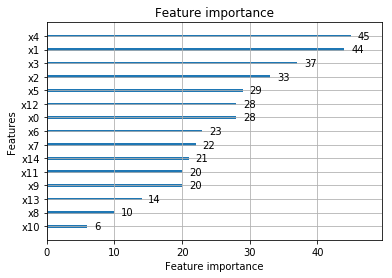

In [2]:
# this works just fine (all importance weights are equal to one)

weights_train = np.ones(len(df_train))
weights_test = np.ones(len(df_test))
def evalerror(pred_y, obs_y):
    if len(pred_y)==len(weights_test):
        weights = weights_test
    else:
        weights = weights_train
    return evalerror_w(pred_y, obs_y, weights)

lgb_train = lgb.Dataset(train, df_train['y'].values, feature_name=variables, weight=weights_train)
lgb_eval = lgb.Dataset(test, df_test['y'].values, reference=lgb_train, feature_name=variables, weight=weights_test)

print "training without importance weights ...."
print "1) notice how mae metric decreases during boosting"
print "2) notice how LightGBM mae metric and custom mae metric give consistent results"

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=nrounds,
                valid_sets=[lgb_train, lgb_eval],  feval=evalerror)

lgb.plot_importance(gbm)
plt.show()


In [3]:
# this produces pathological score (realistic dispersion among importance weights)

weights_train = df_train['weight']
weights_test = df_test['weight']
def evalerror(pred_y, obs_y):
    if len(pred_y)==len(weights_test):
        weights = weights_test
    else:
        weights = weights_train
    return evalerror_w(pred_y, obs_y, weights)

lgb_train = lgb.Dataset(train, df_train['y'].values, feature_name=variables, weight=weights_train)
lgb_eval = lgb.Dataset(test, df_test['y'].values, reference=lgb_train, feature_name=variables, weight=weights_test)

print ""
print ""
print "training with importance weights ...."
print "1) notice how mae metric increases during boosting"
print "2) notice how LightGBM mae metric is consistent with custom mae metric only on validation set"
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=nrounds,
                valid_sets=[lgb_train, lgb_eval], feval=evalerror)

lgb.plot_importance(gbm)
plt.show()

KeyError: 'weight'